In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Постановка задачи

Целью данной работы является создание алгоритма для распознавание визуальных образов(классификации изображений).  
Попробуем решить данную задачу с помощью двух подходов:

1) Cозданием собственного варианта свёрточной нейронной сети.

2) Fine-Tuning сети resnet34. (Метод использования предварительно обученных архитектур — Fine-Tuning (дообучение).)

## Описание набора данных:
Данные состоят из изображений - отрывков из мультсериала Симпсоны. Каждая картинка представлена в формате jpg c необходимой   
меткой - названием персонажа изображенного на ней. Метки классов представлены в виде названий папок, в которых лежат картинки.

Выбор данного датасета обусловлен доступностью и тем, что он потенциально позволяет создать модель для выполнения  
многоклассовой  классификации с использованием изображений, из которых каждое имеет необходимую метку. А также возможностями  
имеющихся вычислительных ресурсов. В данном  датасете данные несбалансированы. Это важно, поскольку многие реальные  
датасеты также могут быть несбалансированными, и  использование такого датасета позволит нам разработать и  протестировать модели,  
которые могут работать с такими данными.

**Импорт библиотек**

In [ ]:
import pickle
import numpy as np
import pandas as pd
import torch
import shutil
import random
import time
import copy
from collections import Counter
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

# PyTorch model and training necessities
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import cuda

# Image datasets and image manipulation
from torchvision import transforms, datasets, utils, models

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
# DEVICE = torch.device("cuda")
# Выбор cpu или cuda
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

## Предварительная обработка данных

In [ ]:
# Очистка локальной директории если  необходимо
# shutil.rmtree("/kaggle/working")

In [ ]:
# Копируем фаилы в локальную директорию
!cp -r "/kaggle/input/simpsons-dataset" "./"

In [ ]:
TRAIN_DIR = Path('/kaggle/working/simpsons-dataset/simpsons_dataset/train_dataset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
len(train_val_files),

(20933,)

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]

# split original DataFrame into training and testing sets
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, random_state=124)

#print size of each set
print(len(train_files), len(val_files))

15699 5234


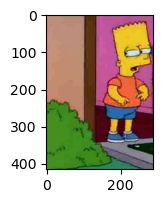

In [ ]:
# Посмотрим на случайное изображение
file_path = train_val_files[2959]
image = Image.open(file_path)
image.load()
plt.figure(figsize = (20,2))
plt.imshow(image)

In [ ]:
image.size

(288, 416)

Посмотрим на распеределение количества картинок по персонажам

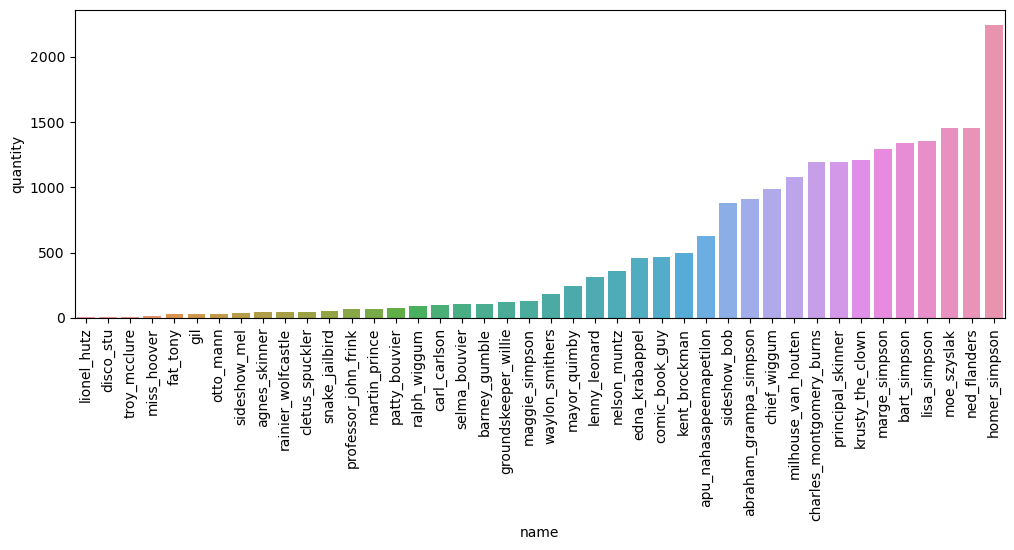

In [ ]:
data = pd.DataFrame(train_val_labels, columns=['name'])
data['quantity'] = 1
data = data.groupby('name').count().sort_values('quantity')

plt.figure(figsize=(12,4))
sns.barplot(x=data.index , y='quantity', data=data).set_xticklabels(data.index, rotation=90)
plt.show()

Из диаграммы видно, что для некоторых персонажей количество картинок очень мало. Данные распределены
неравномерно.    
Поэтому чтобы увеличить количество картинок для повышения точности предсказания
будем использовать аугментацию.   

Создадим класс MyDataset наследующий от Dataset.  
В PyTorch датасетом считается любой объект, для которого определены методы len(self) и getitem(self, i).

In [ ]:
class MyDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в тензоры PyTorch
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        # LabelEncoder - это служебный класс, помогающий нормализовать метки таким
        # образом, чтобы они содержали только значения от 0 до n_classes-1.
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
#     plt.pause(0.001)  # pause a bit so that plots are updated

**Аугментация данных** — это синтез новых данных из уже имеющихся данных. Это когда к имеющемуся набору  
данных применяются различные преобразования, такие как поворот, масштабирование, обрезка, изменение  
цвета и т.д., для создания дополнительных примеров данных. Это позволяет увеличивать размер тренировочного  
набора данных и улучшать обобщающую способность модели.   



Существует множество вариантов аугментации. Одними из самых популярных являются следующие: отражение по  
горизонтали (horizontal flip), случайное кадрирование (random crop) и изменение цвета (color jitter).  
Можно применять различные комбинации, например, одновременно выполнять поворот и случайное  
масштабирование. Кроме того, можно варьировать величину насыщенности (saturation) и значения (value)  
всех пикселей (компоненты S и V цветового пространства HSV).  

Комбинируем различные приемы: отражение по горизонтали (horizontal flip), случайное  
кадрирование (random crop) и изменение цвета (color jitter), вращение, ресайз.

transforms.Compose позволяет нам составлять несколько преобразований вместе, чтобы мы  
могли использовать более одного преобразования.

In [ ]:
augmentations = {
    'Rotation': transforms.RandomRotation(degrees=(-25, 25)),
    'Rotation_Flip': transforms.Compose([
                                transforms.RandomRotation(degrees=(-25, 25)),
                                transforms.RandomHorizontalFlip(p=1),
                                ]),
    'ColorJitter': transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    'HorizontalFlip': transforms.RandomHorizontalFlip(p=1),
    'Resize_Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Resize_Flip_Rotation': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.RandomHorizontalFlip(p=1),
                                transforms.RandomRotation(degrees=(-30, 30))
                                ])
}

In [ ]:
# инстанцируем датасет
train_dataset = MyDataset(train_val_files, mode='train')

Посмотрим на пример изображений после аугментации

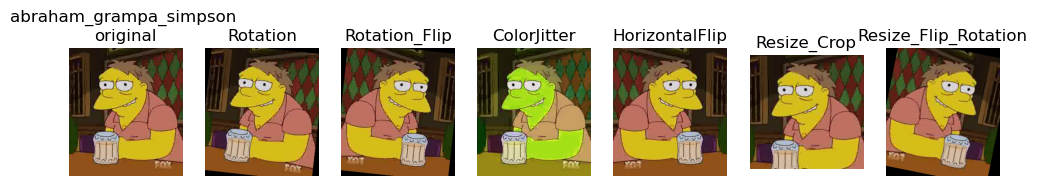

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=7,figsize=(12, 3))

image = train_dataset.load_sample(train_val_files[1667]) # оригинальная картинка
label = train_val_files[10].parent.name

ax[0].imshow(image)
ax[0].set_title(label + " \noriginal")
ax[0].axis('off')

for i, (aug_name, augmen) in enumerate(augmentations.items()):
    img_aug = augmen(image)
    ax[i+1].imshow(img_aug)
    ax[i+1].set_title(aug_name)
    ax[i+1].axis('off')

Определим количество картинок, которое необходимо добавить.

In [ ]:
final_number = 1800
total_number = dict(Counter([x.parent.name for x in train_val_files]))
data = pd.DataFrame(data = total_number.values(), index=total_number.keys(), columns=['total_number'])
need_to_add = data['total_number'] < final_number
data.loc[need_to_add, 'quantity_add'] = (final_number - data['total_number']).astype(int)
data.loc[~need_to_add, 'quantity_add'] = 0
# Количество фаилов, которое нужно добавить на одну картинку
data['quantity_per_image'] = (np.ceil(data['quantity_add'] / data['total_number'])).astype(int)

In [ ]:
data.sort_values(by='total_number', ascending=True)

,total_number,quantity_add,quantity_per_image
lionel_hutz,3,1797.0,599
disco_stu,8,1792.0,224
troy_mcclure,8,1792.0,224
miss_hoover,17,1783.0,105
fat_tony,27,1773.0,66
gil,27,1773.0,66
otto_mann,32,1768.0,56
sideshow_mel,40,1760.0,44
agnes_skinner,42,1758.0,42
rainier_wolfcastle,45,1755.0,39


Произведем аугментацию

In [ ]:
for image in tqdm(train_files):
    path_image = image.parents[0]
    characters_name = image.parent.name # название персонажа
    file_image = train_dataset.load_sample(image)

    # пропуск итерации если не нужно добавлять
    if data.loc[characters_name]['quantity_add'] <= 0:
        continue

    if data.loc[characters_name]['quantity_per_image'] > data.loc[characters_name]['quantity_add']:
        iter_size = data.loc[characters_name]['quantity_add']
    else:
        iter_size = data.loc[characters_name]['quantity_per_image']
    data.loc[characters_name]['quantity_add'] -= iter_size

    for i in range(int(iter_size)):
        augmentation_method = random.choice(list(augmentations.values()))
        augmented_image = augmentation_method(file_image)
        augmented_image.save(f"{path_image}/{image.name.split('.')[0]}_{i}.jpg")

  0%|          | 0/15699 [00:00<?, ?it/s]/tmp/ipykernel_28/2954413052.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[characters_name]['quantity_add'] -= iter_size
100%|██████████| 15699/15699 [04:31<00:00, 57.87it/s] 


Распределение после аугментации

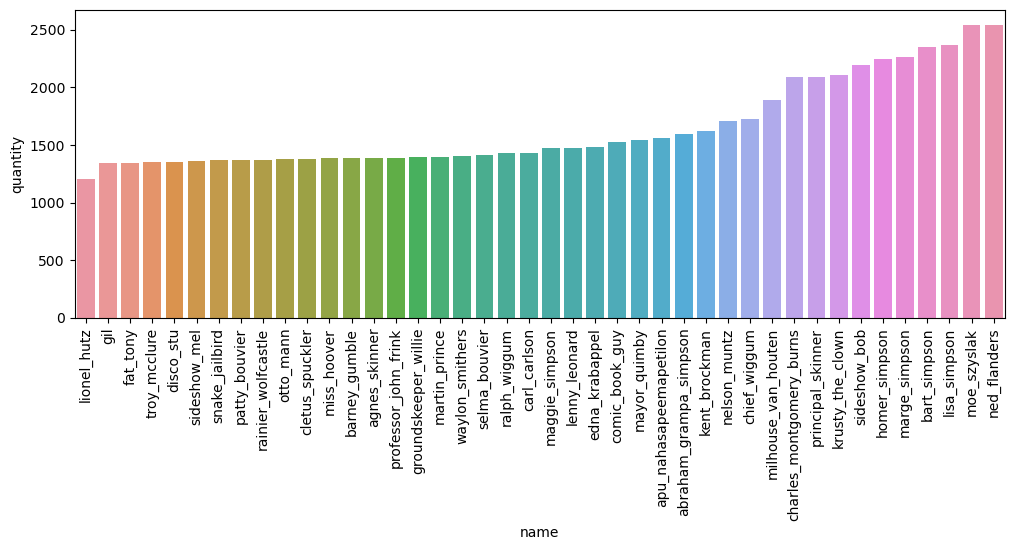

In [ ]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

augmented_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
augmented_labels = [path.parent.name for path in augmented_files]

data = pd.DataFrame(augmented_labels, columns=['name'])
data['quantity'] = 1
data = data.groupby('name').count().sort_values('quantity')

plt.figure(figsize=(12,4))
sns.barplot(x=data.index , y='quantity', data=data).set_xticklabels(data.index, rotation=90)
plt.show()

Сбалансированность данных значительно улучшилась после аугментации, однако, данный набор данных все еще не идеально сбалансирован.

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
train_files, _ = train_test_split(train_val_files, test_size=0.25,
                                  stratify=train_val_labels, random_state=124)

val_dataset = MyDataset(val_files, mode='val')
train_dataset = MyDataset(train_files, mode='train')

Посмотрим на персонажей

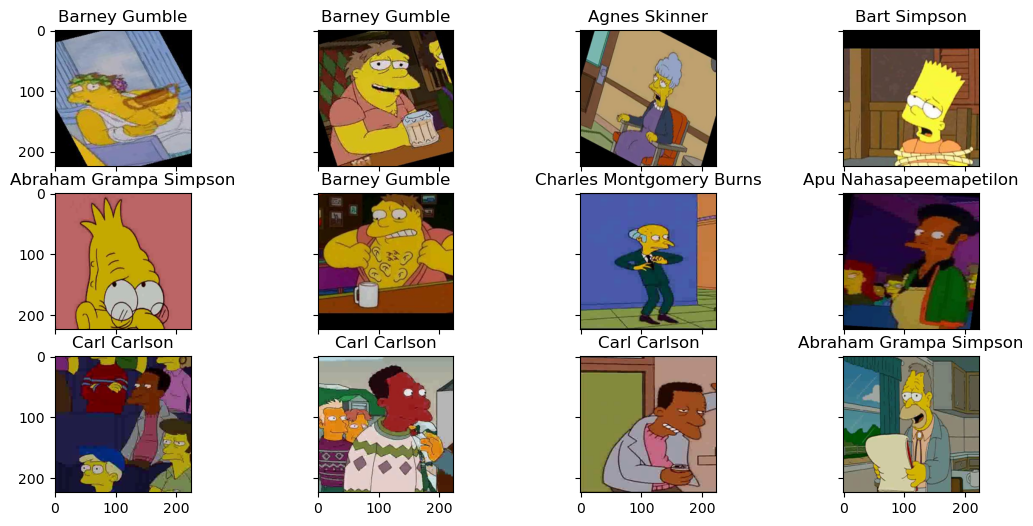

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=4,figsize=(13, 6), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Построение модели
## Построение cвёрточной нейросети

Свёрточная нейросеть (Convolutional Neural Network, CNN) - это многослойная нейросеть, имеющая в своей архитектуре помимо    
полносвязных слоёв (а иногда их может и не быть) ещё и свёрточные слои (Conv Layers) и pooling-слои (Pool Layers).

Описание элементов и структуры модели:   

Добавил BatchNorm в каждый Conv слой, создал self.linear с двумя полносвязными слоями(nn.Linear) и дропаутом(nn.Dropout).  

nn.Dropout в качестве параметра предусматривает использование коэффициента прореживания, определяющего  
вероятность деактивации нейрона. Идея дропаута состоит в том, что во время обучения мы зануляем случайную часть  
входа и отдаем вход дальше (для каждого числа мы с вероятностью p зануляем это число). Дропаут позволяет  
тренировать более устойчивые сети и избегать переобучения.  У него есть один гиперпараметр  p.  

Слой ReLU выполняет роль функции активации, которая присваивает всем входящим признакам значения не меньше нуля.  
При применении этого слоя все отрицательные числа заменяются нулями, а положительные сохраняются без изменений.  

BatchNorm2d - пакетная нормализация (англ. batch-normalization) — метод, который позволяет повысить производительность и   
стабилизировать работу искусственных нейронных сетей. Суть данного метода заключается в том, что некоторым слоям нейронной   
сети на вход подаются данные, предварительно обработанные и имеющие нулевое математическое ожидание и единичную дисперсию.  
Слой BatchNorm2d применяет нормализацию входа так, чтобы среднее значение и вариантность элементов стали нулевыми.  
Это повышает точность работы сети. BatchNorm2d принимает в качестве параметра количество каналов, которые он получает с   
выхода предыдущего слоя.  
В статье (http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43442.pdf) для сверточных слоев    
батчнорм предлагают использовать сразу после свертки до активации.

Батчнорм и дропаут в одной сети использовать можно.
Для этого все Dropout"ы должны идти после BatchNorm"ов.  

Слой MaxPool позволяет сделать так, чтобы расположение объекта в изображении не влияло на способность нейронной  
сети обнаруживать его признаки.Maxpooling сохраняет наиболее активные пиксели из предыдущего слоя, укрупняет масштаб  
полученных признаков. Другими словами, ключевые области, которые определяют изображение к определённому классу,  
делает более крупными.  

Чтобы определить нейронную сеть в PyTorch, мы создаем класс, наследуемый от nn.Module. Мы определяем слои   
сети в функции __init__ и указываем, как данные будут проходить через сеть, в функции forward:

In [ ]:
# Define model(neural network)
class MyCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # nn.Sequential ordered container of modules
        # The data is passed through all the modules in the same order as defined
        self.conv1 = nn.Sequential(
            # Convolution (Свёрточный слой Conv2D)
            # First 2D convolutional layer, taking in 3 input channels (image),
            # outputting 8 convolutional features, with a square kernel size of 3
            # out_channels is the number of feature maps
            # необходмо заранее знать, сколько каналов у картинки (сейчас = 3)
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            # Batch Normalization (Пакетная нормализация)- 2D
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(96 * 5 * 5, 96 * 5 * 5),
            nn.ReLU(),
            # During training, randomly zeroes some of the elements of the input tensor with probability p
            nn.Dropout(0.3),
            # The linear layer is a module that applies a linear transformation
            # on the input using its stored weights and biases.
            # Also known as Fully-connected layer
            nn.Linear(96 * 5 * 5, 96 * 5 * 5),
            # Non-linear activations applied after linear
            # transformations to introduce nonlinearity
            nn.ReLU(),
        )

        # Fully connected layer that outputs our n_classes labels
        self.out = nn.Linear(96 * 5 * 5, n_classes)

    # x represents our data
    def forward(self, x): # задаётся прямой проход
        # Pass data through conv1
        x = self.conv1(x) # выход первого слоя
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.linear(x)

        logits = self.out(x)
        return logits

In [ ]:
# fit_epoch обучение (тренировка) модели
# функция fit_epoch делает проход по всем данным. Это называется эпохой обучения.
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Clear gradients
        optimizer.zero_grad() # обнуляем градиенты

        # Forward propagation
        outputs = model(inputs) # прямое распространение
        # вычислеяем - функцию потерь (loss)
        loss = criterion(outputs, labels) # вычисляем ошибку(функцию потерь)
        # Calculating gradients
        loss.backward() # вычисляем градиенты
        # Update parameters
        # выполним шаг оптимизации
        optimizer.step() # пытаемся оптимизировать значение весов исходя из потерь и градиента
        preds = torch.argmax(outputs, 1)
        # выведем текущий loss
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
# Ф-я обучения сети
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    # Создаем оптимизатор (который будет минимизировать ошибку)
    # Оптимизатору передаются параметры модели.
    optimizer = torch.optim.AdamW(model.parameters())
    # Создаем функцию потерь (Cost function) или
    # функцию ошибки(то, что следует минимизировать)
    criterion = nn.CrossEntropyLoss()
    # schdeuler уменьшающий learning rate
    # Снижает скорость обучения каждой группы параметров по гамме каждую эпоху
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.6)

    lrs = []

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # запускаем главный тренировочный цикл
        for epoch in range(epochs):
            # обучение на тренировочном датасете train_loader
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            # проверка (валидация) (после каждой эпохи)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            lrs.append(optimizer.param_groups[0]["lr"])
            scheduler.step()

    plt.title('Learning rate graph')
    plt.plot(lrs)
    plt.show()
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :42


In [ ]:
# Инстанцируем сеть
my_cnn = MyCnn(n_classes).to(DEVICE) # экземпляр сети

**Вывод структуры сети**

In [ ]:
# Простейший способ увидеть слои сети, это просто вывести на печать модель:
print(my_cnn)

MyCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
# Number of Epochs - the number of times to iterate over the dataset
# Каждый полный проход по данным называется эпохой (epoch)
# Если будет слишком мало эпох, модель не обучится всему, чему могла бы обучиться.
# Если их будет слишком много, она переобучится, то есть запомнит все
# тренировочные данные, а за их пределами работать нормально не сможет.
# Выбираем количество эпох эмпирическим путем:
epochs = 13

# Batch Size - the number of data samples propagated through the network before the parameters are updated
# Batch size – это гиперпараметр, который определяет, сколько данных из обучающей выборки
# будет передано на обработку за одну итерацию обучения нейронной сети. При выборе значения
# batch size следует учитывать доступные ресурсы, такие как объем доступной оперативной
# памяти, наличие подходящей аппаратной архитектуры и прочие возможности вычислительных
# ресурсов. Корректный выбор batch size может способствовать ускорению обучения и повышению
# точности модели, что является ключевыми параметрами для эффективного использования нейронных сетей.
# Чем больше batch size, тем больше оперативная память и вычислительная мощность требуются для
# тренеровки модели, но с увеличением batch size может улучшаться скорость обучения и
# увеличиваться точность модели.
batch_size = 128

epoch:   0%|          | 0/13 [00:00<?, ?it/s]

loss 1.9457662119801105


epoch:   8%|▊         | 1/13 [05:52<1:10:24, 352.06s/it]


Epoch 001 train_loss: 1.9458     val_loss 1.2406 train_acc 0.4724 val_acc 0.6433
loss 0.618229392445386


epoch:  15%|█▌        | 2/13 [11:39<1:04:03, 349.41s/it]


Epoch 002 train_loss: 0.6182     val_loss 0.6716 train_acc 0.8228 val_acc 0.8023
loss 0.2913205675042893


epoch:  23%|██▎       | 3/13 [17:22<57:45, 346.55s/it]  


Epoch 003 train_loss: 0.2913     val_loss 0.4201 train_acc 0.9126 val_acc 0.8814
loss 0.14921879009216277


epoch:  31%|███       | 4/13 [23:08<51:55, 346.21s/it]


Epoch 004 train_loss: 0.1492     val_loss 0.3352 train_acc 0.9566 val_acc 0.9115
loss 0.07720989908211952


epoch:  38%|███▊      | 5/13 [28:52<46:03, 345.44s/it]


Epoch 005 train_loss: 0.0772     val_loss 0.2727 train_acc 0.9788 val_acc 0.9377
loss 0.041737729091347986


epoch:  46%|████▌     | 6/13 [34:33<40:07, 343.96s/it]


Epoch 006 train_loss: 0.0417     val_loss 0.2501 train_acc 0.9903 val_acc 0.9475
loss 0.025030072132818156


epoch:  54%|█████▍    | 7/13 [40:16<34:22, 343.75s/it]


Epoch 007 train_loss: 0.0250     val_loss 0.2525 train_acc 0.9956 val_acc 0.9538
loss 0.017258259140041178


epoch:  62%|██████▏   | 8/13 [46:04<28:44, 344.85s/it]


Epoch 008 train_loss: 0.0173     val_loss 0.2506 train_acc 0.9976 val_acc 0.9549
loss 0.013325143832056595


epoch:  69%|██████▉   | 9/13 [51:53<23:04, 346.17s/it]


Epoch 009 train_loss: 0.0133     val_loss 0.2555 train_acc 0.9986 val_acc 0.9566
loss 0.011263954892237752


epoch:  77%|███████▋  | 10/13 [57:42<17:21, 347.27s/it]


Epoch 010 train_loss: 0.0113     val_loss 0.2590 train_acc 0.9989 val_acc 0.9566
loss 0.01012236239550086


epoch:  85%|████████▍ | 11/13 [1:03:30<11:34, 347.28s/it]


Epoch 011 train_loss: 0.0101     val_loss 0.2598 train_acc 0.9992 val_acc 0.9572
loss 0.009359562035527992


epoch:  92%|█████████▏| 12/13 [1:09:16<05:47, 347.07s/it]


Epoch 012 train_loss: 0.0094     val_loss 0.2609 train_acc 0.9993 val_acc 0.9572
loss 0.008901707225771683


epoch: 100%|██████████| 13/13 [1:15:04<00:00, 346.52s/it]



Epoch 013 train_loss: 0.0089     val_loss 0.2623 train_acc 0.9994 val_acc 0.9568


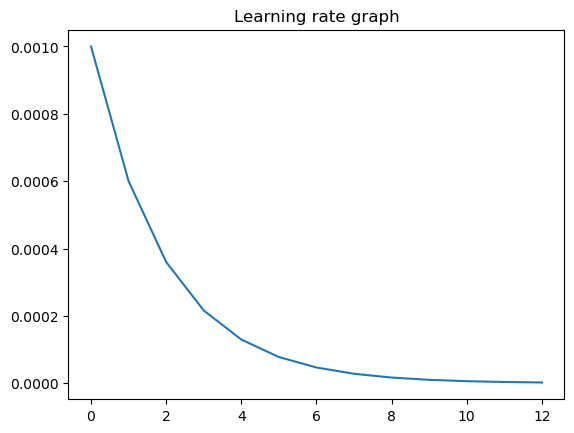

In [ ]:
# Тренируем нашу сеть
logs = train(train_dataset, val_dataset, model=my_cnn, epochs=epochs, batch_size=batch_size)

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*logs)

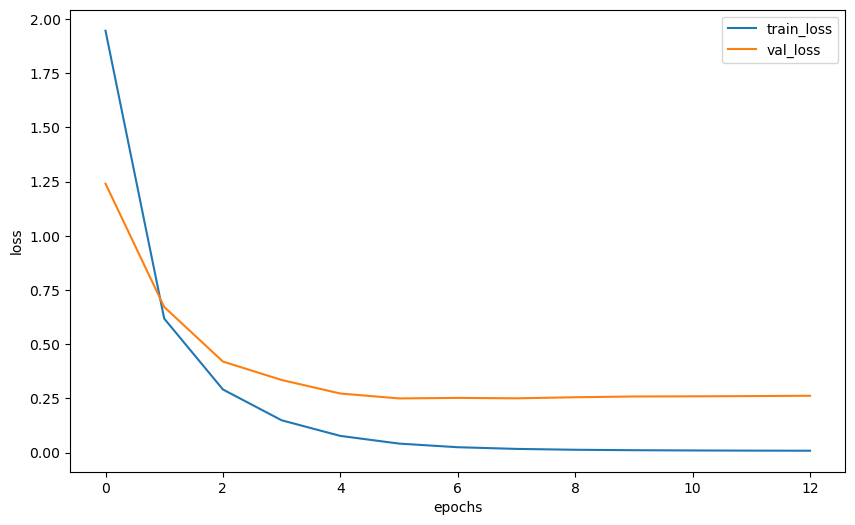

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 30)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

## Выбор метрики

При использовании моделей классификации в машинном/глубоком обучении часто используют две метрики для оценки   
качества модели: f1-score и accuracy.   
Для обеих метрик чем выше значение, тем лучше модель способна классифицировать наблюдения по классам.

Когда имеются несбалансированные данные, метрики, такие как accuracy, могут давать искаженные результаты,  
так как в данном случае количество правильно угаданных значений может быть недостаточным для оценки качества  
решения. Например, если у вас есть 90% данных класса 1 и только 10% данных класса 2, то модель, которая  
всегда прогнозирует класс 1, будет иметь accuracy 90%, хотя это будет некорректный результат. В этом случае  
метрики, такие как precision и recall, могут дать более точные результаты, учитывая несбалансированность классов.  

Понятно что чем выше точность и полнота, тем лучше. Но в реальной жизни максимальная точность и полнота  
не достижимы одновременно и приходится искать некий баланс. Поэтому, хотелось бы иметь некую метрику которая  
объединяла бы в себе информацию о точности и полноте нашего алгоритма. В этом случае нам будет проще принимать   
решение о том какую реализацию запускать в production (у кого больше тот и лучше).  

Модели очень удобно сравнивать, когда их качество выражено одним числом. В случае пары precision-recall  
существует популярный способ скомпоновать их в одну метрику - взять их среднее гармоническое.  
Данный показатель эффективности исторически носит название f1-меры (f1-score). Она стремится к нулю,  
если точность или полнота стремится к нулю.

Вычислим целевую метрику на валидационной выборке f1-score.

In [ ]:
print(actual_labels)
print(y_pred) # предсказанные
f1_score(actual_labels, y_pred, average='micro')

[2, 5, 2, 2, 4, 0, 4, 4, 0, 4, 2, 4, 6, 4, 0, 0, 4, 3, 6, 0, 6, 4, 6, 3, 2, 0, 0, 4, 4, 0]
[ 2  5  2  2  4  0  4  4  0  4  2  4  6 20 38  0  4  3  6  0  6  4  6  3
  2  0  0  4  4  0]


0.9333333333333333

 ## Fine-Tuning сети resnet34

In [ ]:
# # Будем использовать те же train_files и val_files, что и для собственной CNN
val_dataset = MyDataset(val_files, mode='val')
train_dataset = MyDataset(train_files, mode='train')

In [ ]:
n_classes = len(np.unique(train_val_labels))
n_classes # 42

42

Fine-Tuning сети resnet34   
Загрузим предварительно обученную модель и изменим полносвязный слой.

In [ ]:
# Load the pretrained model from torchvision
resnet_model= models.resnet34(pretrained=True)

# Read the input of the last layer:
number_features = resnet_model.fc.in_features # in_feature is the number of inputs for linear layer
print(number_features) # 512

# Substitute the FC output layer:
# replace the last fully-connected layer with linear layer where
# input = number_features and output = n_classes
resnet_model.fc = nn.Linear(number_features, n_classes)
# nn.Linear - fully-connected layer(полносвязный слой)

if torch.cuda.is_available():
    resnet_model = resnet_model.cuda()
    print('Training with cuda')

n_classes, resnet_model.fc # (42, Linear(in_features=512, out_features=42, bias=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512
Training with cuda


(42, Linear(in_features=512, out_features=42, bias=True))

Визуализация модели:

In [ ]:
for name, child in resnet_model.named_children(): print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
resnet_model = resnet_model.to(DEVICE)

# выбираем функцию потерь
criterion_ft = nn.CrossEntropyLoss()
# Cкорость оптимизации или обучения, lr (learning rate) определяет величину изменений, которую оптимайзер может внести за один раз.
# Чем больше lr, тем быстрее модель будет обучаться, но также можно обнаружить, что шаги, которые позволяете оптимайзеру делать,
# на самом деле могут быть слишком велики, и алгоритм не улучшается, а просто застревает на месте, прыгая туда-сюда. Если взять
# данный параметр слишком маленьким, то модель будет заметно дольше обучаться и точно так же может застревать на месте.
# выбираем алгоритм оптимизации и learning_rate:
learning_rate_resnet = 1e-3
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(resnet_model.parameters(), lr=learning_rate_resnet, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Создадим новую функцию для обучения нейросети, чтобы в нее можно было передавать дополнительные параметры

In [ ]:
def train_modified(train_dataset, val_dataset, model, epochs, batch_size, optimizer, criterion, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    lrs = []

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # запускаем главный тренировочный цикл
        for epoch in range(epochs):
            # обучение на тренировочном датасете train_loader
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            # проверка (валидация) (после каждой эпохи)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            lrs.append(optimizer.param_groups[0]["lr"])
            scheduler.step()

    plt.title('Learning rate graph')
    plt.plot(lrs)
    plt.show()
    return history


Тренируем модель

In [ ]:
# Выбираем количество эпох опытным путем:
epochs_ft = 6

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 1.542220696027109


epoch:  17%|█▋        | 1/6 [08:54<44:31, 534.32s/it]


Epoch 001 train_loss: 1.5422     val_loss 0.3538 train_acc 0.6964 val_acc 0.9348
loss 0.16276278770153693


epoch:  33%|███▎      | 2/6 [17:39<35:15, 528.85s/it]


Epoch 002 train_loss: 0.1628     val_loss 0.1567 train_acc 0.9583 val_acc 0.9582
loss 0.059083953157268276


epoch:  50%|█████     | 3/6 [26:22<26:19, 526.42s/it]


Epoch 003 train_loss: 0.0591     val_loss 0.0940 train_acc 0.9853 val_acc 0.9788
loss 0.025092506970499636


epoch:  67%|██████▋   | 4/6 [35:03<17:28, 524.30s/it]


Epoch 004 train_loss: 0.0251     val_loss 0.0562 train_acc 0.9941 val_acc 0.9883
loss 0.011567908057472839


epoch:  83%|████████▎ | 5/6 [43:44<08:42, 522.86s/it]


Epoch 005 train_loss: 0.0116     val_loss 0.0487 train_acc 0.9972 val_acc 0.9912
loss 0.003983403858271121


epoch: 100%|██████████| 6/6 [52:12<00:00, 522.08s/it]



Epoch 006 train_loss: 0.0040     val_loss 0.0519 train_acc 0.9993 val_acc 0.9920


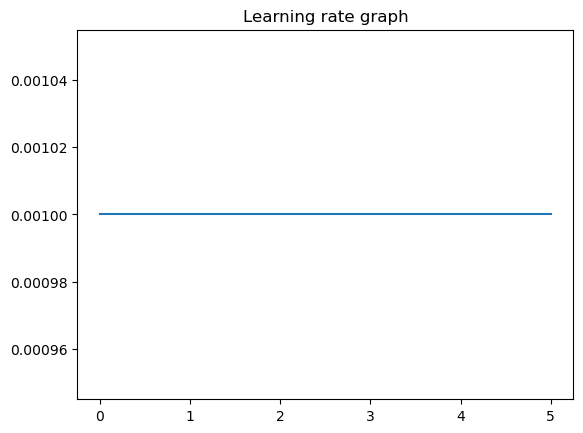

In [ ]:
logs_ft = train_modified(train_dataset, val_dataset, model=resnet_model, epochs=epochs_ft, \
                          batch_size=128, optimizer=optimizer_ft, criterion=criterion_ft, scheduler=exp_lr_scheduler)

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*logs_ft)

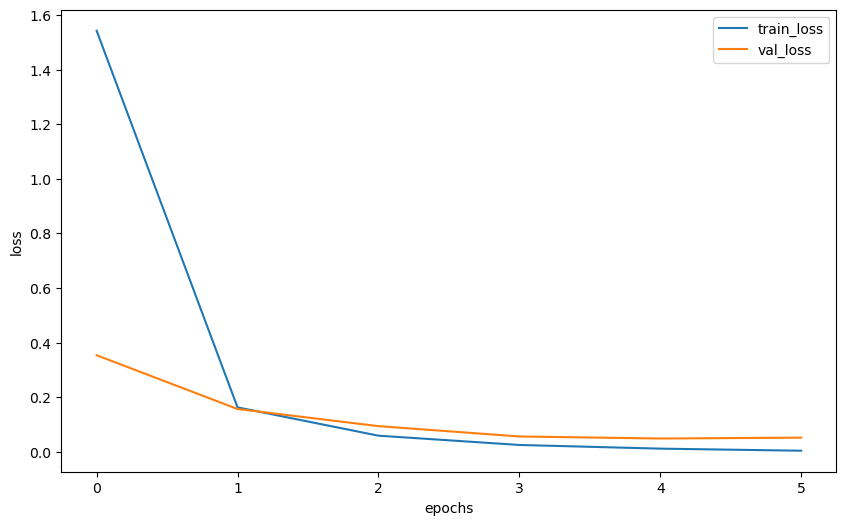

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet_model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 30)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet_model, imgs)

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Вычислим целевую метрику на валидационной выборке f1-score.

In [ ]:
print(actual_labels)
print(y_pred) # предсказанные
f1_score(actual_labels, y_pred, average='micro')

[0, 6, 4, 4, 2, 0, 6, 4, 6, 4, 6, 2, 2, 0, 2, 2, 0, 2, 2, 4, 4, 4, 6, 0, 6, 2, 4, 3, 5, 6]
[0 6 4 4 2 0 6 4 6 4 6 2 2 0 2 2 0 2 2 4 4 4 6 0 6 2 4 3 5 6]


1.0

# Оценка результатов

Были разработаны две модели глубокого обучения для многоклассовой классификации изображений. Обе модели показали   
высокую эффективность при тестировании на контрольных данных.   
По метрике f1-score модель полученная с помощью fine-tuning сети resnet34 показала лучший результат(f1-score = 1.0).

f1-score модели на основе собственного варианта свёрточной нейронной сети  равен 0.93(3), что является как минимум  
удовлетворительным результатом.

Возможности для улучшения модели:   
В процессе создания моделей применялась аугментация данных. Хотя она и является эффективной методикой для улучшения  
"производительности" модели глубокого обучения, она не всегда гарантирует классификацию с высокой точностью для всех классов.  
Это связано с тем, что генерация новых примеров не является заменой реальных данных, и для  некоторых классов может быть  
слишком мало примеров в исходной обучающей выборке, чтобы модель смогла извлечь эффективные признаки для этих классов.  
Для более точной классификации на таких классах следует использовать дополнительные реальные данные для балансировки  
набора обучающих данных.




